# Using SupercheQ with Cirq SuperstaQ

This notebook demonstrates how to use SupercheQ, a novel quantum fingerprinting protocol developed by Super.tech (a division of Infleqtion). SupercheQ is built into the SuperstaQ (Super.tech's write-once-target-all compiler for quantum hardware) server, and can be accessed using cirq-superstaq.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import cirq_superstaq as css

First, we must instantiate the qiskit-superstaq provider. Set your api key using the "api_key" argument. If you don't have it you can find it here https://superstaq.super.tech/.

In [2]:
# provider = css.Service(api_key="Enter Your API Key Here")
provider = css.Service()

To demonstrate SupercheQ, we construct 32 files (for the sake of simplicitly, we just use lists in this notebook), each of length 5-bits. The lists represent the 32 different possible 5 bit values, so in theory these should all have distinguishable fingerprints.

In [3]:
# demonstrate fingerprinting on all 32 5-bit bitstrings. We'll encode into just 3 qubits.
# fmt: off
files = [
    [0, 0, 0, 0, 0], [0, 0, 0, 0, 1], [0, 0, 0, 1, 0], [0, 0, 0, 1, 1],
    [0, 0, 1, 0, 0], [0, 0, 1, 0, 1], [0, 0, 1, 1, 0], [0, 0, 1, 1, 1],
    [0, 1, 0, 0, 0], [0, 1, 0, 0, 1], [0, 1, 0, 1, 0], [0, 1, 0, 1, 1],
    [0, 1, 1, 0, 0], [0, 1, 1, 0, 1], [0, 1, 1, 1, 0], [0, 1, 1, 1, 1],
    [1, 0, 0, 0, 0], [1, 0, 0, 0, 1], [1, 0, 0, 1, 0], [1, 0, 0, 1, 1],
    [1, 0, 1, 0, 0], [1, 0, 1, 0, 1], [1, 0, 1, 1, 0], [1, 0, 1, 1, 1],
    [1, 1, 0, 0, 0], [1, 1, 0, 0, 1], [1, 1, 0, 1, 0], [1, 1, 0, 1, 1],
    [1, 1, 1, 0, 0], [1, 1, 1, 0, 1], [1, 1, 1, 1, 0], [1, 1, 1, 1, 1],
]
# fmt: on

SupercheQ uses quantum volume models to generate random circuits, using the file information as a seed. Hence, the final state vectors of the circuit act as a fingerprint for the file. SupercheQ allows you to choose the number of qubits as well as circuit depth. To start with, we will use 3 qubits with a depth of 1.

In [4]:
num_qubits = 3
depth = 1
circuits, fidelities = provider.supercheq(files, num_qubits, depth)

In [5]:
print(len(circuits))
print(fidelities.shape)

32
(32, 32)


Let's see what a couple of these circuits look like.

### Circuit for file [0, 0, 0, 0, 0]

In [6]:
circuits[0]

0: ───#2──────────────────────────────────────────────────────────I───
      │                                                           │
      ┌                                                       ┐   │
      │ 0.717+0.189j -0.376+0.25j   0.385-0.158j  0.19 -0.193j│   │
1: ───│ 0.082-0.441j  0.177-0.584j  0.461+0.263j  0.217-0.312j│───I───
      │ 0.052+0.048j  0.073-0.375j -0.281-0.634j  0.588+0.147j│   │
      │ 0.396+0.294j  0.252-0.462j -0.176-0.18j  -0.627-0.15j │   │
      └                                                       ┘   │
                                                                  │
2: ───────────────────────────────────────────────────────────────I───

### Circuit for file [0, 0, 0, 0, 1]

In [7]:
circuits[1]

0: ───#2──────────────────────────────────────────────────────────I───
      │                                                           │
1: ───┼───────────────────────────────────────────────────────────I───
      │                                                           │
      ┌                                                       ┐   │
      │ 0.497+0.534j -0.181+0.519j  0.244-0.276j -0.027+0.173j│   │
2: ───│ 0.354-0.223j -0.277-0.424j  0.193-0.341j -0.592-0.255j│───I───
      │-0.199+0.j     0.588+0.006j  0.482+0.011j -0.436+0.437j│
      │ 0.462+0.2j   -0.01 -0.309j -0.314+0.616j -0.19 +0.37j │
      └                                                       ┘

On first glance, these circuits look distinct (which is what we expect). However, we can't know for sure until we study the fidelities. The fidelity is calculated as the inner product of the final state vector pairs. For a good fingerprinting protocol, we would want all identical files to have a fidelity of 1, and distinct pairs to have a fidelity as close to 0 as possible.

The code blocks below allow you to visualize all of the fidelities simultaneously.

In [8]:
def plot_heatmap(fidelities):
    plt.figure(dpi=150)
    plt.imshow(fidelities)
    plt.colorbar()


def plot_histogram(fidelities):
    off_diag = np.tril(fidelities, -1)  # lower-right triangle of fidelities matrix
    on_diag = np.diag(fidelities)
    plt.figure(dpi=150)
    plt.hist([off_diag.flatten(), on_diag], label=["Off-Diagonal", "On-Diagonal"])
    plt.legend()

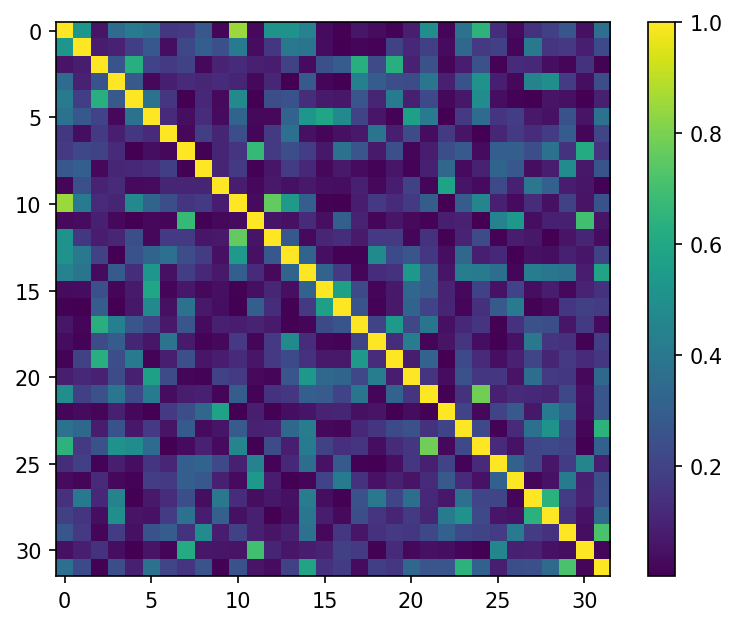

In [9]:
plot_heatmap(fidelities)

The above graph is a heatmap of the 32 different files and their fidelities with each other. It is essentially a visual representation of the fidelity matrix, with shades closer to yellow representing fidelity values close to one, and darker shades closer to blue/violet indication a fidelity close to 0. As expected, we have a yellow diagonal (1s), surrounded by much darker pixels (0s). 

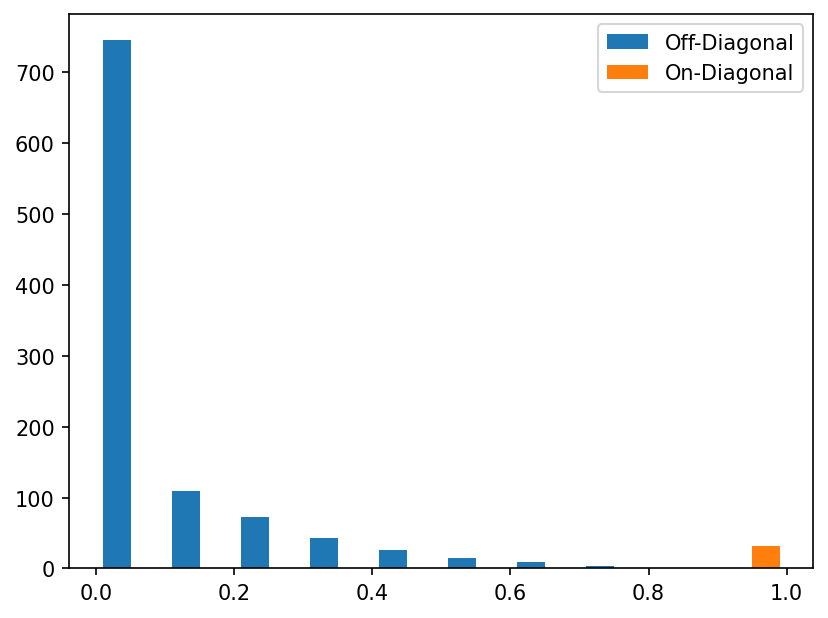

In [10]:
plot_histogram(fidelities)

In [11]:
np.sum(np.isclose(fidelities, 1))

32

We can look at the breakdown of fidelities using a histogram. As expected, there are 32 fidelities close to 1. 75% of the histogram entries are in the 0.0 bar, and the rest are distributed over the 0.1-0.6 range. This is a successful fingerprinting in that it pretty clearly distinguised identical pairs from separate ones, but we can do better and push the non identical fidelities closer to 0. We can achieve this by increasing the depth of the circuit or using more qubits.

---
### Scaling Depth

Instead of a circuit depth of 3, we use 15.

In [12]:
depth = 15
circuits, fidelities = provider.supercheq(files, num_qubits, depth)

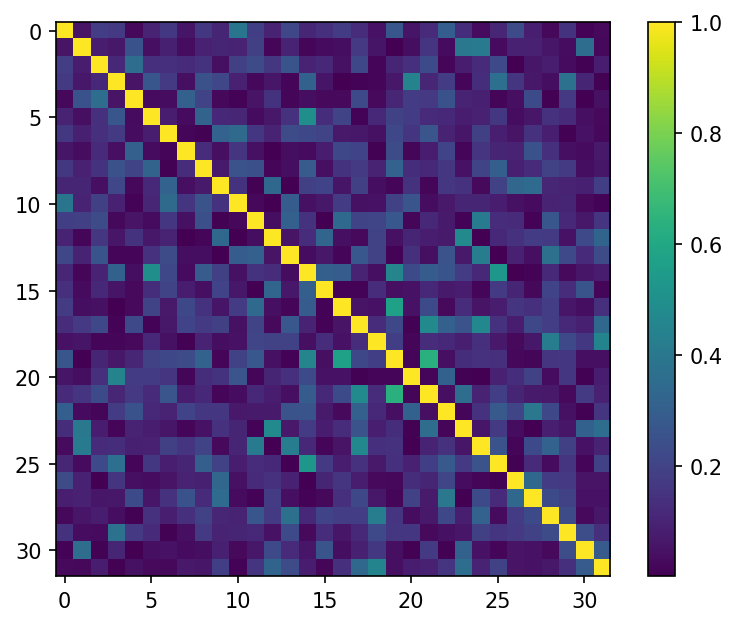

In [13]:
plot_heatmap(fidelities)

We see a visible improvement in results with a circuit depth of 15. There are fewer bright pixels around the diagonal, and the diagonal line is much clearer.

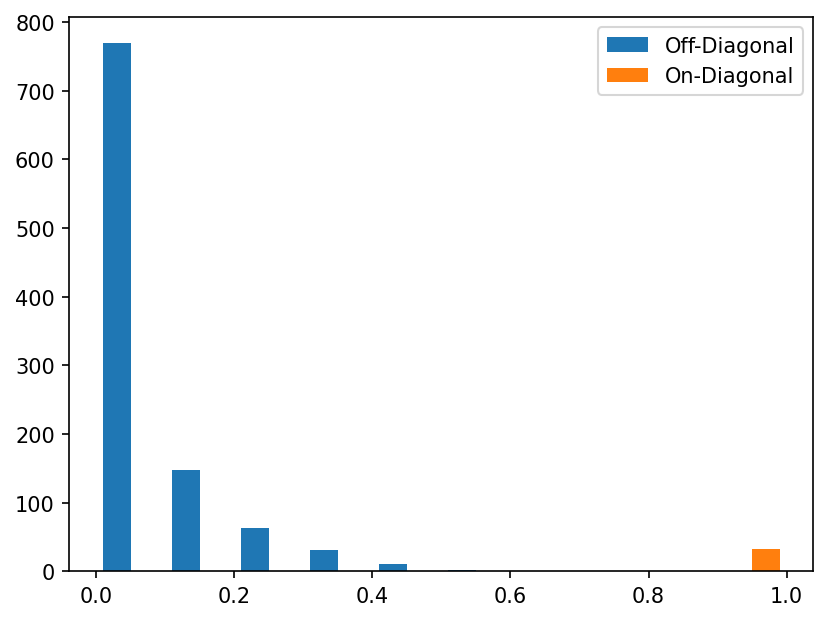

In [14]:
plot_histogram(fidelities)

Notice that the off-diagonals have moved slightly to the left in the histogram. Almost 80% of the pairs are in the 0 bar.

----
## Scaling number of qubits

We can similarly increase the number of qubits used. Here we use 4 instead of 1.

In [15]:
num_qubits = 4
circuits, fidelities = provider.supercheq(files, num_qubits, depth)

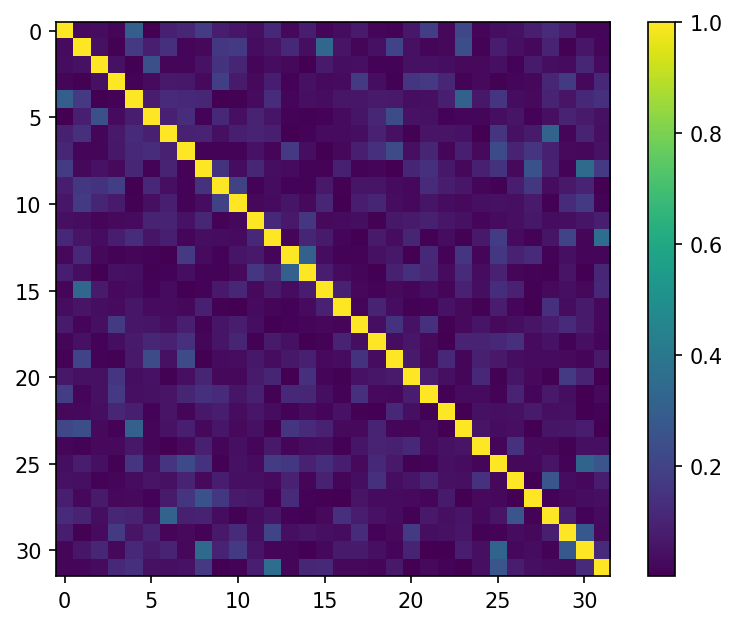

In [16]:
plot_heatmap(fidelities)

Again, we see a performance improvement. In fact, it seems like increasing the qubit count from 1 to 4 was more powerful than the depth increase. The off diagonal elements are all very dark. This is reflected in the histogram below, where about 90% of the off diagonal elements are in the 0.0 bar.

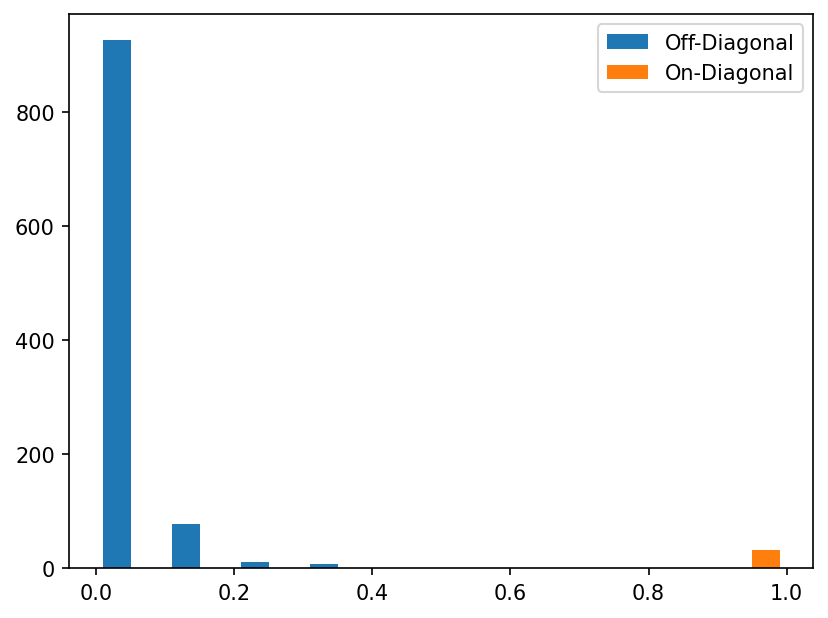

In [17]:
plot_histogram(fidelities)